In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier
     

In [30]:
class Node():
    def __init__(self, feature=None, threshold=None, left=None, right=None,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None

In [57]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if self.n_features is None else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # проверка критерия остановы
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # находим лучший сплит
        

        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        if best_feature is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
            
        # создаём поддеревья
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)

        # 💥 Защита от пустых потомков
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)
        
    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # считаем критерий информативности
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        # энтропия предка
        parent_entropy = self._entropy(y)

        # энтропия потомков
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # взвешенная энтропия потомков
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # считаем информативность
        information_gain = parent_entropy - child_entropy
        return information_gain

    # разбиение на поддеревья
    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    # энтропия
    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])

    # наиболее встречающийся класс
    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    # предсказание
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    # обход дерева
    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [32]:
class RandomForest:
    def __init__(self, n_trees = 10, max_depth = 10,  min_samples_split=2, n_feature=None):
        self.n_trees = n_trees
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.n_features=n_feature
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for i in range (self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth,
                            min_samples_split=self.min_samples_split,
                            n_features=self.n_features)

            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_samples(self, X, y):
        n_samples = X.shape[0]
        number = np.random.choice(n_samples, n_samples, replace=True)
        return X[number], y[number]

    # когда дерево достигло конца (лист),
    # и нельзя (или не нужно) больше делить —
    # мы должны выбрать класс, который предсказывать в этом листе.
    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions

In [33]:
!wget -O "train.csv" -q "https://www.dropbox.com/s/ftutnnm0nfpzo5y/car_evaluation.csv?dl=0"


In [34]:
train = pd.read_csv('train.csv', header= None)
train.sample(3)

,0,1,2,3,4,5,6
285,vhigh,med,4,4,big,low,unacc
790,high,low,3,2,big,med,unacc
1715,low,low,5more,4,med,high,vgood


In [35]:
col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']


train.columns = col_names

col_names

['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

In [36]:
X = train.drop(['class'], axis=1)

y = train['class']

In [37]:

!pip install category_encoders

In [38]:
import category_encoders as ce
encoder = ce.OrdinalEncoder(cols=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])


X = encoder.fit_transform(X)

In [39]:

X.sample(3)

,buying,maint,doors,persons,lug_boot,safety
776,2,4,1,3,1,3
287,1,3,3,2,3,3
1659,4,4,2,2,2,1


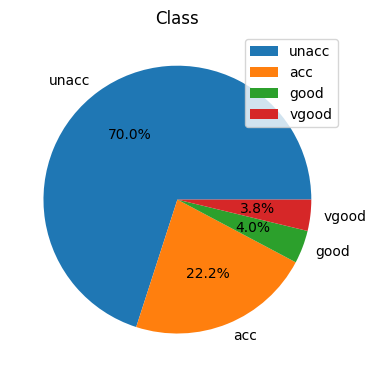

In [40]:
plt.figure(figsize =(20, 20))
data_i=y.value_counts()
plt.subplot(4,4,1)
plt.pie(data_i, labels = data_i.index, autopct='%1.1f%%')
plt.title('Class')
plt.legend()
None
     

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)


In [42]:

clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
     

RandomForestClassifier(random_state=0)

In [43]:

train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

In [44]:
print('f1_train = ', metrics.f1_score(y_train, train_pred, average='macro'))
print('f1_test = ', metrics.f1_score(y_test, test_pred, average='macro'))

print('recall_train = ', metrics.recall_score(y_train, train_pred, average='macro'))
print('recall_test = ', metrics.recall_score(y_test, test_pred, average='macro'))

print('precision_train = ', metrics.precision_score(y_train, train_pred, average='macro'))
print('precision_test = ', metrics.precision_score(y_test, test_pred, average='macro'))

print('accuracy_train = ', metrics.accuracy_score(y_train, train_pred))
print('accuracy_test = ', metrics.accuracy_score(y_test, test_pred))

f1_train =  1.0
f1_test =  0.9028341355410089
recall_train =  1.0
recall_test =  0.9310467557065588
precision_train =  1.0
precision_test =  0.8865945231865744
accuracy_train =  1.0
accuracy_test =  0.9667250437828371


In [45]:
feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores
     

safety      0.294684
persons     0.239810
buying      0.163664
maint       0.150181
lug_boot    0.090393
doors       0.061268
dtype: float64

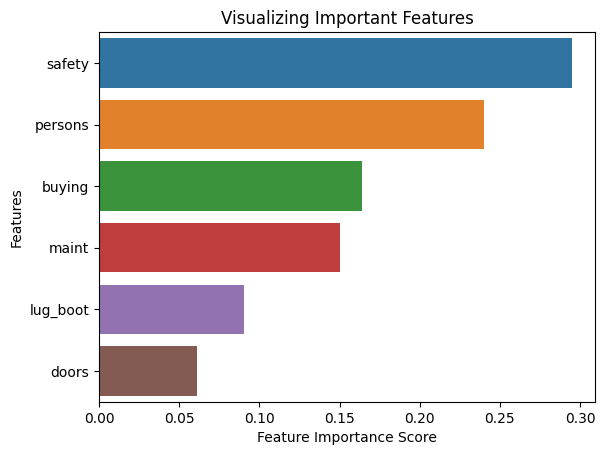

In [46]:

sns.barplot(x=feature_scores, y=feature_scores.index)

plt.xlabel('Feature Importance Score')

plt.ylabel('Features')

plt.title("Visualizing Important Features")

plt.show()

In [47]:

X = train.drop(['class', 'doors'], axis=1)

y = train['class']

In [48]:

encoder = ce.OrdinalEncoder(cols=['buying', 'maint', 'persons', 'lug_boot', 'safety'])


X = encoder.fit_transform(X)
     

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)


In [50]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [51]:
print('f1_train = ', metrics.f1_score(y_train, train_pred, average='macro'))
print('f1_test = ', metrics.f1_score(y_test, test_pred, average='macro'))

print('recall_train = ', metrics.recall_score(y_train, train_pred, average='macro'))
print('recall_test = ', metrics.recall_score(y_test, test_pred, average='macro'))

print('precision_train = ', metrics.precision_score(y_train, train_pred, average='macro'))
print('precision_test = ', metrics.precision_score(y_test, test_pred, average='macro'))

print('accuracy_train = ', metrics.accuracy_score(y_train, train_pred))
print('accuracy_test = ', metrics.accuracy_score(y_test, test_pred))

f1_train =  1.0
f1_test =  0.9028341355410089
recall_train =  1.0
recall_test =  0.9310467557065588
precision_train =  1.0
precision_test =  0.8865945231865744
accuracy_train =  1.0
accuracy_test =  0.9667250437828371


In [52]:
	

from sklearn.metrics import classification_report

print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

         acc       0.96      0.90      0.93       129
        good       0.68      0.95      0.79        20
       unacc       0.99      0.99      0.99       397
       vgood       0.92      0.88      0.90        25

    accuracy                           0.97       571
   macro avg       0.89      0.93      0.90       571
weighted avg       0.97      0.97      0.97       571



My Random Forest

In [58]:
encoder = ce.OrdinalEncoder(cols=['buying', 'maint', 'persons', 'lug_boot', 'safety'])


X = encoder.fit_transform(X)

encoder = ce.OrdinalEncoder(cols=['class'])


y = encoder.fit_transform(y)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)


In [60]:

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy().flatten()
y_test = y_test.to_numpy().flatten()

In [61]:
clf = RandomForest(n_trees = 100)
clf.fit(X_train, y_train)

In [62]:

train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

In [63]:

print('f1_train = ', metrics.f1_score(y_train, train_pred, average='macro'))
print('f1_test = ', metrics.f1_score(y_test, test_pred, average='macro'))

print('recall_train = ', metrics.recall_score(y_train, train_pred, average='macro'))
print('recall_test = ', metrics.recall_score(y_test, test_pred, average='macro'))

print('precision_train = ', metrics.precision_score(y_train, train_pred, average='macro'))
print('precision_test = ', metrics.precision_score(y_test, test_pred, average='macro'))

print('accuracy_train = ', metrics.accuracy_score(y_train, train_pred))
print('accuracy_test = ', metrics.accuracy_score(y_test, test_pred))

f1_train =  0.9379211970949518
f1_test =  0.8311047823144597
recall_train =  0.9470162050059876
recall_test =  0.8741291273700037
precision_train =  0.9296754920215461
precision_test =  0.8082507844910116
accuracy_train =  0.9688850475367329
accuracy_test =  0.9299474605954466


In [64]:

from sklearn.metrics import classification_report

print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           1       0.98      0.97      0.98       397
           2       0.89      0.82      0.85       129
           3       0.80      0.80      0.80        25
           4       0.56      0.90      0.69        20

    accuracy                           0.93       571
   macro avg       0.81      0.87      0.83       571
weighted avg       0.94      0.93      0.93       571

